In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class gradMat:
    @staticmethod
    def redot(a, b):
        return b@a
    
    @staticmethod
    def retrans(_, b):
        return b.T.copy()
    
    @staticmethod
    def mulgrad(a, b):
        c = a*b
        dimensions = [i for i, dim in enumerate(a.shape) if dim == 1]
        c = np.sum(c, axis=tuple(dimensions)).reshape(a.shape)
        return c

    @staticmethod
    def mul(a, b, grad=[0,0], grada=[], gradb=[]):
        if grad[0]:
            for i in range(len(grada)):
                grada[i].append([gradMat.mulgrad, np.ones(a.shape)*b])#mul grad
        if grad[1]:
            for i in range(len(gradb)):
                gradb[i].append([gradMat.mulgrad, np.ones(b.shape)*a])#mul grad
        
        return a*b
    
    @staticmethod
    def add(a, b, grad=[0,0], grada=[], gradb=[]):
        if grad[0]:
            for i in range(len(grada)):
                grada[i].append([gradMat.mulgrad, np.ones(a.shape)])#mul grad
        if grad[1]:
            for i in range(len(gradb)):
                gradb[i].append([gradMat.mulgrad, np.ones(b.shape)])#mul grad
        
        return a+b
    @staticmethod
    def sub(a, b, grad=[0,0], grada=[], gradb=[]):
        if grad[0]:
            for i in range(len(grada)):
                grada[i].append([gradMat.mulgrad, np.ones(a.shape)])#mul grad
        if grad[1]:
            for i in range(len(gradb)):
                gradb[i].append([gradMat.mulgrad, -np.ones(b.shape)])#mul grad
        
        return a-b
    @staticmethod
    def dot(a, b, grad=[0,0], grada=[], gradb=[]):
        if grad[0]:
            for i in range(len(grada)):
                grada[i].append([gradMat.redot, b.T.copy()])#b.T@grad
        if grad[1]:
            for i in range(len(gradb)):
                gradb[i].append([np.dot, a.T.copy()])#grad@a.T
        
        return a@b
    @staticmethod
    def div(a, b, grad=[0,0], grada=[], gradb=[]):
        if grad[0]:
            for i in range(len(grada)):
                grada[i].append([gradMat.mulgrad, np.ones(a.shape)/b])#mul grad
        if grad[1]:
            for i in range(len(gradb)):
                gradb[i].append([gradMat.mulgrad, -a/b**2])#mul grad
        
        return a/b
    
    @staticmethod
    def pow(a, b, grad=[0,0], grada=[], gradb=[]):
        if grad[0]:
            for i in range(len(grada)):
                grada[i].append([gradMat.mulgrad, b*(a**(b-1))])#mul grad
        if grad[1]:
            for i in range(len(gradb)):
                gradb[i].append([gradMat.mulgrad, (a**b)*np.log(a)])#mul grad
        
        return a**b
    
    @staticmethod
    def tran(a, b=None, grad=[0], grada=[], gradb=None):
        if grad[0]:
            for i in range(len(grada)):
                grada[i].append([np.transpose, None])#grad = grad.T

        return a.T.copy()
    
    @staticmethod
    def sum(a, b=None, grad=[0], grada=[], gradb=None):
        if grad[0]:
            for i in range(len(grada)):
                grada[i].append([gradMat.mulgrad, np.ones(a.shape)])#mul grad
        
        return np.sum(a)
    
    @staticmethod
    def backward(x, grad_list=[]):
        grad_list.reverse()
        grad = np.ones(x.shape)
        for act in grad_list:
            grad = act[0](act[1], grad)
        
        return grad   

In [3]:
import numpy as np

class Tensor:
    def __init__(self, data:np, grad=False):
        self.val = data
        self.grad = grad
        self.carry = []
        self.names = []
        if grad:
            self.carry = [[]]
            self.names = [self]
            self.gradient = 0

    def reset(self):
        if self.grad:
            self.gradient = 0
            self.carry = [[]]
            self.names = [self]
        else:
            self.carry = []
            self.names = []

    @staticmethod
    def init(data: np, grad: False):
        a = Tensor(data, grad)
        a.carry = []
        a.names = []
        return a

    def execute(self, function, other):
        re = function(self.val, other.val, [self.grad, other.grad], self.carry, other.carry)
        if self.grad or other.grad:
            ret = Tensor.init(re, True)
            ret.carry = self.carry + other.carry
            ret.names = self.names + other.names
            return ret
        return Tensor(re)

    def __add__(self, other):
        return self.execute(gradMat.add, other)

    def __sub__(self, other):
        return self.execute(gradMat.sub, other)

    def __mul__(self, other):
        return self.execute(gradMat.mul, other)

    def __truediv__(self, other):
        return self.execute(gradMat.div, other)

    def __matmul__(self, other):
        return self.execute(gradMat.dot, other)

    def __pow__(self, other):
        return self.execute(gradMat.pow, other)
    
    def sum(self):
        other = Tensor(np.zeros((1,1)))
        return self.execute(gradMat.sum, other)

    def transpose(self):
        other = Tensor(np.zeros((1,1)))
        return self.execute(gradMat.tran, other)

    def __str__(self):
        return str(self.val)
    
    def backward(self):
        for carr, name in zip(self.carry, self.names):
            grad = gradMat.backward(self.val, carr)
            name.gradient += grad

In [14]:
#generate data
N = 100
x_ = np.arange(N).reshape(N,1)
delta = np.random.uniform(-10,10, size=(N,1))
y_ = 1.5*x_+5+delta
x = Tensor(x_)
y = Tensor(y_)

lr = 0.000001
diff = 4
epoch = 10

w1 = Tensor(np.random.random((1,1)), True)
w2 = Tensor(np.random.random((1,1)), True)

#begin line
start_w1 = w1.val.copy()
start_w2 = w2.val.copy()

x_start = [1, 100]
y_start = [int(w1.val+w2.val), int(w1.val*100+w2.val)]

#training
for i in range(epoch):
    loss = (x@w1+w2-y)**Tensor(np.array([[2]]))
    loss = loss.sum()
    loss.backward()

    print(f'epoch {i}, loss {loss}')

    if int(loss.val / 100) <= diff:
        break

    w1.val -= w1.gradient*lr
    w2.val -= w2.gradient*lr

    w1.reset()
    w2.reset()

#after training line
end_w1 = w1.val.copy()
end_w2 = w2.val.copy()

x_end = [1, 100]
y_end = [int(w1.val+w2.val), int(w1.val*100+w2.val)]

epoch 0, loss 547397.4765374569
epoch 1, loss 67546.41995528326
epoch 2, loss 11042.734326757176
epoch 3, loss 4389.2311710113545
epoch 4, loss 3605.7082377079514
epoch 5, loss 3513.3897565445145
epoch 6, loss 3502.4622863177665
epoch 7, loss 3501.1188113219196
epoch 8, loss 3500.9038808297614
epoch 9, loss 3500.821844954795


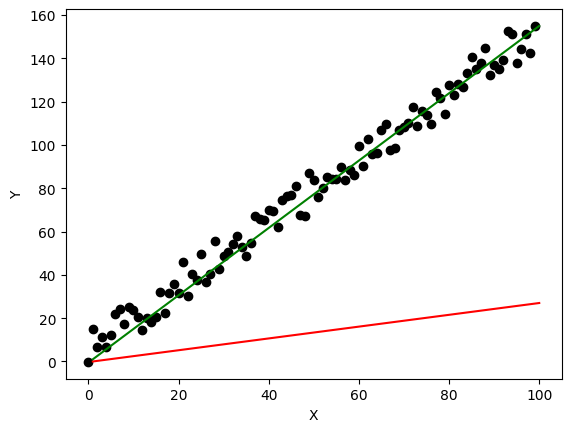

In [15]:
plt.scatter(x_, y_, color='black')
plt.plot(x_start, y_start, color='red')
plt.plot(x_end, y_end, color='green')

plt.xlabel('X')
plt.ylabel('Y')

# Display the plot
plt.show()